In [1]:
import numpy as np
import osmnx as ox
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt

import random
import pickle
import pymde
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from scipy import sparse

import mlrfit as mf
import lrrouting as ldr

import cvxpy as cp
import numba as nb

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

#  Matrix definition

In [3]:
rank = 20

mtype = "small_world"
n = 7020
# G = nx.connected_watts_strogatz_graph(n, k=4, p=0.1)
# G.remove_edges_from(nx.selfloop_edges(G))
# G = nx.DiGraph(G)

beta = 0.7
gamma = 0.01
G = nx.scale_free_graph(n, alpha=1-beta-gamma, beta=beta, gamma=gamma)#alpha=0.41, beta=0.54)

n = G.number_of_nodes()
print(f"{n=}, {G.number_of_edges()=}")

# for u, v in G.edges():
#     G[u][v]['weight'] = np.random.rand() * 10

Adj, Dist, nodes_cc = ldr.nx_graph_to_matrices(G, nodes=True)
G = G.subgraph(nodes_cc)
n = G.number_of_nodes()
A = Dist

n=7020, G.number_of_edges()=23853
[572, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [4]:
# ldr.plot_nx_G(G, with_labels=False, node_size=1, f_layout=nx.spring_layout, width=0.05)

In [5]:
assert nx.is_strongly_connected(G)
np.histogram(Dist.flatten(), bins=5, density=True)

(array([0.00388619, 0.24021957, 0.22737664, 0.02706734, 0.00145025]),
 array([ 0.,  2.,  4.,  6.,  8., 10.]))

In [6]:
adjacency_list = ldr.adjacency_directed_list(Adj)
sources, targets = ldr.st_pairs(n, Dist, 1020)
M = min(1000, sources.size)
sources = sources[:M]
targets = targets[:M]

In [7]:
PSD = False
w_min = A[A>0].min()
rt_max_iters = min(int(5*A.max()/w_min), (10**4) // 2)
symm = np.allclose(A, A.T)
print(f"{symm=}")
filename = "%s_r%d_%d"%(mtype, rank, n)

symm=False


In [8]:
np.histogram(Adj[Adj>0], bins=5, density=True)

(array([1.22064092e-02, 9.26482673e-06, 0.00000000e+00, 4.63241337e-06,
        4.63241337e-06]),
 array([  1. ,  82.8, 164.6, 246.4, 328.2, 410. ]))

In [9]:
info = {} 

In [10]:
fraction_of_nodes = 0.5
pi_rows = np.random.permutation(n)[:int(n * fraction_of_nodes)]
pi_cols = np.random.permutation(n)[:int(n * fraction_of_nodes)+10]

pi_row_Dist = ldr.sparse_sampled_matrix(pi_rows, Dist, rows=True)
pi_col_Dist_T = ldr.sparse_sampled_matrix(pi_cols, Dist, rows=False)

rDist = np.zeros((n, n))
rDist[pi_rows] = Dist[pi_rows]
assert np.allclose(pi_row_Dist.toarray(), rDist)

cDist = np.zeros((n, n))
cDist[:, pi_cols] = Dist[:, pi_cols]
assert np.allclose(pi_col_Dist_T.T.toarray(), cDist)
print("PASSED")

rDist = Dist[pi_rows]
cDist = Dist[:, pi_cols].T

pi_rows_c = np.delete(np.arange(n), pi_rows)
pi_cols_c = np.delete(np.arange(n), pi_cols)

PASSED


# test computation of product $B^k Z^k$

In [11]:
for _ in range(10):
    Z0 = np.random.randn(2*n, rank//2)
    X, Y = Z0[:n], Z0[n:]

    d_X = np.einsum('ik,ik->i', X, X)
    d_Y = np.einsum('ik,ik->i', Y, Y)

    res3 = ldr.form_B_compute_BZ(Z0, n, rDist, cDist, pi_rows, pi_cols)
    res1 = ldr.product_BZ(X, Y, d_X, d_Y, pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist)
    assert np.allclose(res1, res3)
    
print("PASSED")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


PASSED


In [12]:
%timeit ldr.product_BZ(X, Y, d_X, d_Y, pi_rows, pi_cols, pi_rows_c, pi_cols_c, rDist, cDist)

15.2 ms ± 478 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit ldr.form_B_compute_BZ(Z0, n, rDist, cDist, pi_rows, pi_cols)

3.02 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# test computation of product $Lb$

In [14]:
L = ldr.laplacian_from_row_col_pi(pi_rows, pi_cols, n, debug=False)


L2 = np.zeros((2*n, 2*n))
for i in pi_rows:
    for j in range(n):
        L2[i, i] += 1
        L2[n+j, n+j] += 1
        L2[i, n+j] = -1
        L2[n+j, i] = -1
for j in pi_cols:
    for i in range(n):
        if L2[i, n+j] == -1: continue
        L2[i, i] += 1
        L2[n+j, n+j] += 1
        L2[i, n+j] = -1
        L2[n+j, i] = -1

assert (np.allclose(L2, L)) and (np.allclose(np.linalg.norm(L.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L.sum(axis=1)), 0))
assert (np.allclose(np.linalg.norm(L2.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L2.sum(axis=1)), 0))

print("PASSED")

PASSED


In [15]:
D_minsqrt = np.power(np.diag(L), -0.5)
N = (D_minsqrt[:, np.newaxis] * L) * D_minsqrt[np.newaxis, :]

assert np.allclose(N, np.diag(D_minsqrt) @ L @ np.diag(D_minsqrt)) and np.allclose(np.ones(L.shape[0]), np.diag(N))
print("PASSED")

PASSED


In [16]:
for i in range(2*n):
    b0 = np.eye(2*n)[i]#np.random.randn(2*n)
    res3 = L @ b0
    res1 = ldr.product_Lb(b0, pi_rows, pi_cols, pi_rows_c, pi_cols_c, n)
    assert np.allclose(res1, res3)
print("PASSED")

PASSED


In [17]:
%timeit L @ b0

98.3 µs ± 7.38 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
%timeit ldr.product_Lb(b0, pi_rows, pi_cols, pi_rows_c, pi_cols_c, n)

5.46 µs ± 152 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# tests for CG convergence for $Ax=b$ with $A \succ 0$

In [19]:
def cg_Ax_b(A, b, diag_precond=True, D=None, eps=1e-10, max_iter=100, printing=False):
    if diag_precond:
        if D is None: D = np.diag(A)
    else:
        D = np.ones(b.shape[0])
    D_inv = 1 / D
    x = np.zeros(b.shape[0])
    r = b 
    z = D_inv * r
    rho0 = np.dot(r, z)
    b_norm = np.linalg.norm(b, ord=2)
    p = z + 0
    losses = []
    for k in range(max_iter):
        Ap = np.dot(A, p)
        if ldr.is_close_scalar(np.linalg.norm(Ap, ord=2), 0):
            return x, losses[:k]
        alpha = np.dot(r, z) / np.dot(p, Ap)
        x += alpha * p 
        r -= alpha * Ap
        z = D_inv * r
        rho1 = np.dot(r, z)
        p = (rho1/rho0) * p + z
        losses += [np.sqrt(np.dot(r, r)) / b_norm]
        if printing: print(k, losses[-1], np.linalg.norm(A @ x - b, ord=2), rho0, rho1)
        if losses[-1] < eps: break
        rho0 = rho1
    return x, losses

In [20]:
for t in range(10):
    A0 = np.random.randn(2*n, 2*n)
    A0 = A0 @ A0.T + 1e-5 * np.eye(2*n)
    b0 = np.random.randn(2*n)
    
    x2 = np.linalg.solve(A0, b0)
    # x2 = np.linalg.lstsq(A, b0)[0] # A0 is PD
    x_cg, losses = cg_Ax_b(A0, b0, diag_precond=True, eps=1e-20, max_iter=5000, printing=False)
    print(len(losses), losses[-1])
    
    assert np.allclose(A0 @ x2, A0 @ x_cg), print(t, np.linalg.norm(b0 - A0 @ x2), np.linalg.norm(b0 - A0 @ x_cg))

print("PASSED")

2185 1.6576557319006942e-10
2513 2.928149465711686e-10
2189 1.6249931829629595e-10
2209 2.1197981049172145e-10
2704 2.9941073958115693e-10
2220 2.1095584278850664e-10
2192 1.683843831615928e-10
2180 1.3569395417497612e-10
2228 1.8935138737355384e-10
2182 1.3068628920943558e-10
PASSED


# CG for $Lx=b$ with Laplacian $L\succeq 0$, with $b \in \mathcal{R}(L)$

In [21]:
D = ldr.diag_Laplacian(pi_rows, pi_cols, pi_rows_c, pi_cols_c, n)
D_inv = 1/D
assert np.allclose(D, np.diag(L))

In [22]:
for _ in range(10):
    for b0 in [L @ np.random.randn(L.shape[0]), np.random.randn(L.shape[0])]:
        # x2 = np.linalg.solve(L, b0)
        x2 = np.linalg.lstsq(L, b0, rcond=1e-8)[0]
        x_cg, losses = ldr.cg_Laplacian_system(b0, D_inv, pi_rows, pi_cols, pi_rows_c, pi_cols_c, n, eps=1e-12, max_iter=2000, printing=False)
        print(len(losses), losses[-1])
        assert np.allclose(np.linalg.norm(b0 - L @ x2), np.linalg.norm(b0 - L @ x_cg))

print("PASSED")

5 8.909214964221334e-15
5 5.431538220228485e-14
5 6.854581378616724e-15
5 1.381826994870388e-14
5 7.486147665033722e-15
5 2.7269370363952165e-14
5 8.21283892818009e-15
5 2.4261812708052232e-14
5 1.9507482453408186e-14
5 2.3224619861506408e-14
5 1.2708385422829528e-14
5 1.427031045612258e-14
5 7.807560275571254e-15
5 2.846885700102606e-13
5 8.493945610377282e-15
5 2.447103273027878e-14
5 1.303610596716395e-14
5 1.5498993261405916e-14
5 1.2856785554578611e-14
5 2.4613037916183485e-14
PASSED


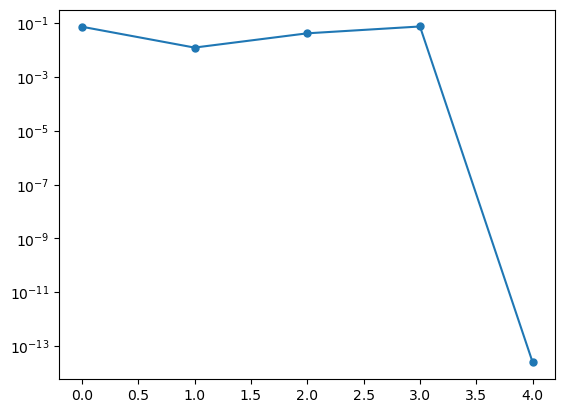

In [23]:
plt.plot(losses, marker='o', ms=5)
plt.yscale('log')

# Symmetric embedding

In [24]:
L = ldr.laplacian_from_pi(pi_rows, n, debug=False)
L2 = np.zeros((n, n))

for i in pi_rows:
    for j in range(n):
        if j == i or L2[i, j] == -1: continue
        L2[i, i] += 1
        L2[j, j] += 1
        L2[i, j] = -1
        L2[j, i] = -1

assert (np.allclose(L2, L)) and (np.allclose(np.linalg.norm(L.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L.sum(axis=1)), 0))
assert (np.allclose(np.linalg.norm(L2.sum(axis=0)), 0) and np.allclose(np.linalg.norm(L2.sum(axis=1)), 0))
# print(L2,"\n\n",  L)
print("PASSED")

PASSED


In [25]:
D = ldr.symm_diag_Laplacian(pi_rows, pi_rows_c, n)
D_inv = 1/D

assert np.allclose(D, np.diag(L))

In [26]:
for _ in range(10):
    for b0 in [L @ np.random.randn(L.shape[0]), np.random.randn(L.shape[0])]:
        # x2 = np.linalg.solve(L, b0)
        x2 = np.linalg.lstsq(L, b0, rcond=1e-8)[0]
        x_cg, losses = ldr.symm_cg_Laplacian_system(b0, D_inv, pi_rows, pi_rows_c, n, eps=1e-12, max_iter=2000, printing=False)
        print(len(losses), losses[-1])
        assert np.allclose(np.linalg.norm(b0 - L @ x2), np.linalg.norm(b0 - L @ x_cg))

print("PASSED")

4 1.0575491928744892e-15
4 2.598221348000997e-15
4 1.1819796292266148e-15
4 2.3001791653226164e-14
4 9.656694832333808e-16
4 5.508058338035758e-15
4 1.504249265956353e-16
4 2.2318605558086044e-15
4 7.478953047282248e-17
4 8.095388547807827e-15
4 2.4267908964869698e-17
4 9.633170672625457e-14
4 3.3787075876552558e-15
4 1.0737935649015454e-13
4 1.948419891299721e-15
4 3.0682967101314274e-14
4 3.036556858418652e-15
4 2.7934821912211965e-14
4 2.664224795544131e-16
4 2.2029857511117738e-14
PASSED


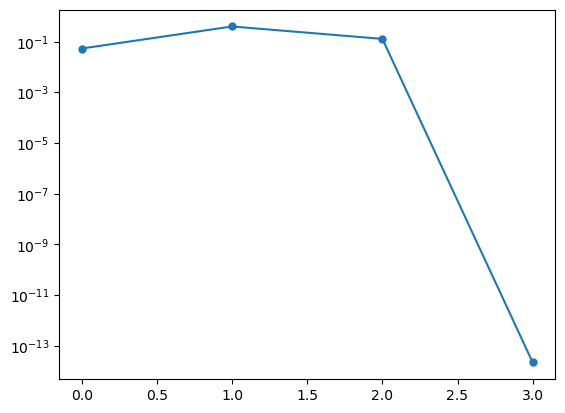

In [27]:
plt.plot(losses, marker='o', ms=5)
plt.yscale('log')